In [1]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_probability as tfp
tfd = tfp.distributions
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler, ModelCheckpoint

print("TF version:", tf.__version__)
print("TFP version:", tfp.__version__)

#    TF version: 2.4.0
#    TFP version: 0.12.0

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.utils import shuffle

TF version: 2.9.1
TFP version: 0.14.0


In [2]:
N = 1000

data1 = pd.DataFrame({'f': 0,
                      'x': np.random.uniform(low=0, high=1, size=N),
                      'y': np.random.randn(N)})

data2 = pd.DataFrame({'f': 1,
                      'x': np.random.uniform(low=0, high=1, size=N),
                      'y': 10 + np.random.randn(N)})

data = pd.concat([data1, data2])

data = shuffle(data)

In [3]:
data.head()

,f,x,y
237,1,0.106285,9.283531
792,0,0.570627,-0.812197
51,0,0.346427,0.887619
509,1,0.480613,8.201754
165,1,0.994001,10.031910


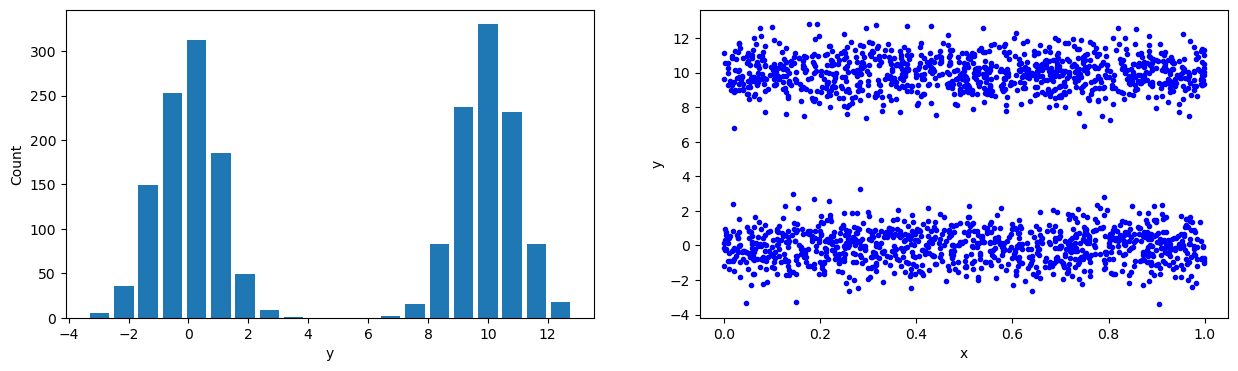

In [4]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.hist(data['y'], bins=20, rwidth=0.8)
plt.xlabel('y')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.plot(data['x'], data['y'], 'b.')
plt.xlabel('x')
plt.ylabel('y');

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data.drop(['y'],axis=1).values, 
                                                    data['y'].values, 
                                                    test_size=0.50, random_state=42)

# scale train/test data because buiding a neural net
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))

X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

In [6]:
model = keras.Sequential(name='normal_estimator')

model.add(layers.Dense(50,input_dim=X_train.shape[1],activation='relu'))
model.add(layers.Dense(10,activation='relu'))

model.add(layers.Dense(2))
model.add(tfp.layers.IndependentNormal(1))

def negative_loglikelihood(targets, estimated_distribution):
    return -estimated_distribution.log_prob(targets)

# model.compile(optimizer='adam', loss='mse')
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01)
# model.compile(optimizer='adam', loss=negative_loglikelihood)
model.compile(optimizer=optimizer, loss=negative_loglikelihood)

# model.summary()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  min_delta=0,
                                                  patience=20,
                                                  verbose=0,
                                                  mode="auto",
                                                  baseline=None,
                                                  restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0001)

model.fit(x=X_train,
          y=y_train,
          validation_data=(X_test,y_test),
          batch_size=1024,
          epochs=250,
          callbacks=[reduce_lr, early_stopping])

Epoch 1/250
1/1 [==============================] - 1s 527ms/step - loss: 61.2344 - val_loss: 36.3856 - lr: 0.0100
Epoch 2/250
1/1 [==============================] - 0s 24ms/step - loss: 38.4249 - val_loss: 25.8837 - lr: 0.0100
Epoch 3/250
1/1 [==============================] - 0s 23ms/step - loss: 27.3890 - val_loss: 19.8906 - lr: 0.0100
Epoch 4/250
1/1 [==============================] - 0s 24ms/step - loss: 20.9997 - val_loss: 15.5807 - lr: 0.0100
Epoch 5/250
1/1 [==============================] - 0s 24ms/step - loss: 16.4010 - val_loss: 12.2870 - lr: 0.0100
Epoch 6/250
1/1 [==============================] - 0s 24ms/step - loss: 12.8979 - val_loss: 9.8126 - lr: 0.0100
Epoch 7/250
1/1 [==============================] - 0s 24ms/step - loss: 10.2749 - val_loss: 7.9552 - lr: 0.0100
Epoch 8/250
1/1 [==============================] - 0s 24ms/step - loss: 8.3111 - val_loss: 6.5694 - lr: 0.0100
Epoch 9/250
1/1 [==============================] - 0s 25ms/step - loss: 6.8472 - val_loss: 5.5420 -

<AxesSubplot:>

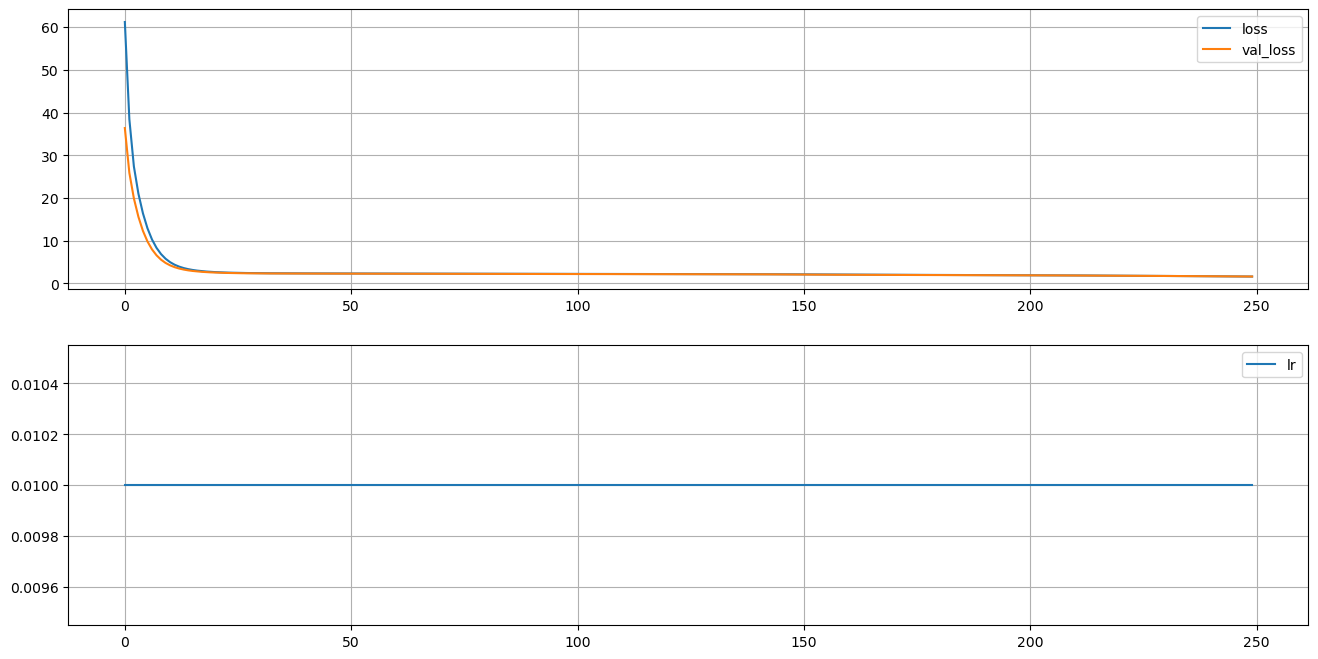

In [7]:
losses = pd.DataFrame(model.history.history)

plt.figure(figsize=(16,8))
ax1 = plt.subplot(2,1,1)
losses[['loss','val_loss']].plot(ax=ax1,grid=True)
# losses[['loss','val_loss']].plot(figsize=(16,4),grid=True)
ax2 = plt.subplot(2,1,2)
losses[['lr']].plot(ax=ax2,grid=True)
# losses[['lr']].plot(figsize=(16,4),grid=True)

In [8]:
prediction_distribution = model(X_test)

In [9]:
prediction_mean = [x[0] for x in prediction_distribution.mean().numpy().tolist()]

In [10]:
prediction_stdv = [x[0] for x in prediction_distribution.stddev().numpy().tolist()]

In [11]:
# The 95% CI is computed as mean ± (1.96 * stdv)
upper = list()
lower = list()

for i in range(len(prediction_mean)):
    upper.append( (prediction_mean[i] + (1.96 * prediction_stdv[i])) )
    lower.append( (prediction_mean[i] - (1.96 * prediction_stdv[i])) )


sample = 20

for idx in range(sample):
    print(
        f"Prediction mean: {round(prediction_mean[idx], 2)}, "
        f"stddev: {round(prediction_stdv[idx], 2)}, "
        f"95% CI: [{round(upper[idx], 2)} - {round(lower[idx], 2)}]"
        f" - Actual: {np.round(y_test[idx],1)}"
    )

Prediction mean: 9.63, stddev: 2.05, 95% CI: [13.66 - 5.6] - Actual: 9.2
Prediction mean: 0.06, stddev: 0.97, 95% CI: [1.97 - -1.85] - Actual: 0.2
Prediction mean: 9.63, stddev: 2.05, 95% CI: [13.65 - 5.6] - Actual: 9.3
Prediction mean: 9.79, stddev: 2.08, 95% CI: [13.87 - 5.72] - Actual: 11.6
Prediction mean: 9.87, stddev: 2.09, 95% CI: [13.97 - 5.77] - Actual: 10.6
Prediction mean: 0.06, stddev: 1.03, 95% CI: [2.08 - -1.96] - Actual: -0.4
Prediction mean: 0.06, stddev: 1.01, 95% CI: [2.03 - -1.91] - Actual: 1.5
Prediction mean: 0.06, stddev: 0.91, 95% CI: [1.86 - -1.73] - Actual: 0.9
Prediction mean: 0.06, stddev: 0.95, 95% CI: [1.93 - -1.8] - Actual: 0.3
Prediction mean: 0.06, stddev: 1.01, 95% CI: [2.04 - -1.92] - Actual: -0.1
Prediction mean: 9.88, stddev: 2.1, 95% CI: [13.99 - 5.77] - Actual: 9.5
Prediction mean: 0.06, stddev: 0.94, 95% CI: [1.91 - -1.79] - Actual: -1.0
Prediction mean: 9.76, stddev: 2.08, 95% CI: [13.83 - 5.69] - Actual: 8.8
Prediction mean: 0.06, stddev: 0.95, 